# IMF Commodity Price Forecast

DESCRIPTION

You are provided with a dataset which consists of Zinc prices for the period Jan 1980 – Feb 2016.

Objective: Obtain a time series model to analyze Zinc prices.

Actions to Perform:
    
Visualize the time series

Check for the stationarity of your data using Rolling Statistics and Dickey-Fuller test and if present, remove it using the stationarity removal techniques

Plot ACF and PACF plots. Find the p, d, and q values

Perform ARIMA modeling

Forecast the prices using the new model

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pyplot import rcParams
rcParams['figure.figsize']=(10,6)

import seaborn as sns

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf,pacf,adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

from pandas.plotting import autocorrelation_plot,lag_plot

import warnings
warnings.filterwarnings('ignore')

In [30]:
#Loading data
df= pd.read_csv(r"C:\Users\admin\Desktop\ML\Lesson 8 practice\zinc_prices_IMF.csv", index_col=0, parse_dates=['Date'])

In [6]:
df.head()

,Price
Date,
1980-01-01,773.82
1980-02-01,868.62
1980-03-01,740.75
1980-04-01,707.68
1980-05-01,701.07


In [7]:
df.shape

(434, 1)

In [8]:
df.columns

Index(['Price'], dtype='object')

In [9]:
df.index

DatetimeIndex(['1980-01-01', '1980-02-01', '1980-03-01', '1980-04-01',
               '1980-05-01', '1980-06-01', '1980-07-01', '1980-08-01',
               '1980-09-01', '1980-10-01',
               ...
               '2015-05-01', '2015-06-01', '2015-07-01', '2015-08-01',
               '2015-09-01', '2015-10-01', '2015-11-01', '2015-12-01',
               '2016-01-01', '2016-02-01'],
              dtype='datetime64[ns]', name='Date', length=434, freq=None)

In [10]:
#Visualize the time series

Text(0.5, 1.0, 'IMF commodity timeseries')

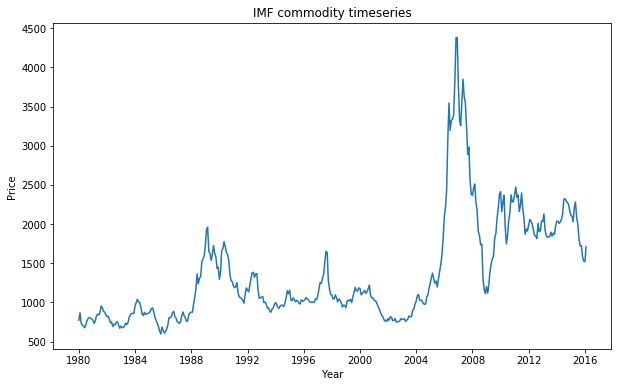

In [31]:
plt.plot(df)
plt.xlabel('Year')
plt.ylabel('Price')
plt.title('IMF commodity timeseries')

In [17]:
#Check for the stationarity of your data using Rolling Statistics and Dickey-Fuller test and if present, 
#remove it using the stationarity removal techniques

In [21]:
def test_stationarity(timeseries):
    rolmean=timeseries.rolling(window=12).mean()
    rolstd=timeseries.rolling(window=12).std()
    
    orig=plt.plot(timeseries,color='blue',label='Original')
    rolm=plt.plot(rolmean,color='red',label='Rolmean')
    rols=plt.plot(rolstd,color='green',label='Rolstd')
    plt.legend(loc='best')
    plt.show()
    
    df_test=adfuller(timeseries)
    df_output=pd.Series(df_test[0:4],index=['Test Statistic','p_value','Lags','No of Obs'])
    for key, value in df_test[4].items():
        df_output['Critical Value {}'.format(key)] =value
    print(df_output)
    
    if (df_test[1] <0.05):
        print("Data is stationary, Reject H0")
    else:
        print("Data is Non stationary, Accept H0")

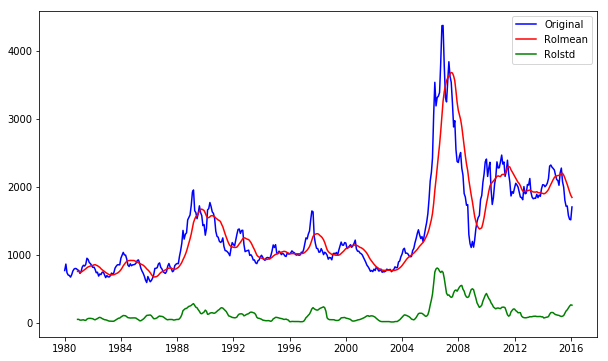

Test Statistic         -3.139601
p_value                 0.023758
Lags                    7.000000
No of Obs             426.000000
Critical Value 1%      -3.445794
Critical Value 5%      -2.868349
Critical Value 10%     -2.570397
dtype: float64
Data is stationary, Reject H0


In [32]:
test_stationarity(df['Price'])

Original data is found to be stationary, as per the ADF test, but visually rolmean and rolstd is not found to be constant.
Applying differencing to remove the stationarity , if any existent

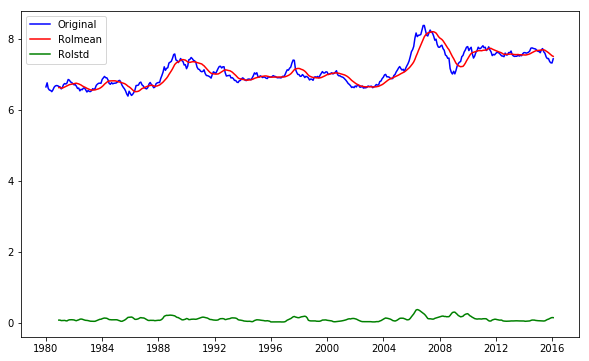

Test Statistic         -1.986978
p_value                 0.292312
Lags                    1.000000
No of Obs             432.000000
Critical Value 1%      -3.445578
Critical Value 5%      -2.868254
Critical Value 10%     -2.570346
dtype: float64
Data is Non stationary, Accept H0


In [29]:
df_log=np.log(df)
df_log.dropna(inplace=True)
test_stationarity(df_log['Price'])

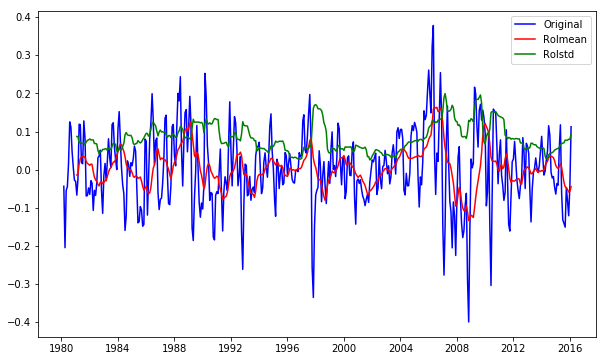

Test Statistic         -5.101779
p_value                 0.000014
Lags                   17.000000
No of Obs             414.000000
Critical Value 1%      -3.446244
Critical Value 5%      -2.868547
Critical Value 10%     -2.570502
dtype: float64
Data is stationary, Reject H0


In [35]:
#Differencing
df_log_diff= df_log - df_log.shift(2)
df_log_diff.dropna(inplace=True)
test_stationarity(df_log_diff['Price'])

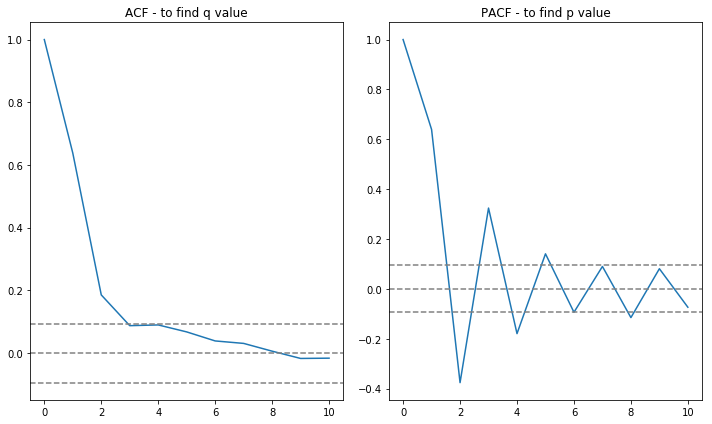

In [37]:
#Plot ACF and PACF plots. Find the p, d, and q values

acf_value=acf(df_log_diff,nlags=10)
pacf_value=pacf(df_log_diff,nlags=10)

plt.subplot(121)
plt.plot(acf_value)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(df_log_diff)),linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df_log_diff)),linestyle='--',color='gray')
plt.title('ACF - to find q value')

plt.subplot(122)
plt.plot(pacf_value)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(df_log_diff)),linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df_log_diff)),linestyle='--',color='gray')
plt.title('PACF - to find p value')
plt.tight_layout()
plt.show()

p= 2 to 4, 
q= 0 to 2,
d=2

In [42]:
# make traindata and testdata
len(df)
#434*0.8

434

In [44]:
traindata=df.iloc[0:len(df)-100]
testdata=df.iloc[len(traindata):len(df)]
traindata.shape,testdata.shape

((334, 1), (100, 1))

In [70]:
#Perform ARIMA modeling
#To check optimal values of p,d,q
import itertools
p=d=q=range(0,10)
aic_list=[]
param_list=[]
for param in (itertools.product(p,d,q)):
    try:
        model=ARIMA(traindata,order=param)
        model_ar_fit=model.fit()
        param_list.append(param)
        aic_list.append(model_ar_fit.aic)
    except:
        continue

In [69]:
param_aic_list=[]
for i in zip(param_list,aic_list):
    param_aic_list.append(i)
sorted(param_aic_list, key=lambda x: x[1],reverse=False)[0]

((3, 2, 3), 3967.427291432413)

In [71]:
model=ARIMA(traindata,order=(3,2,3))
model_ar_fit=model.fit()

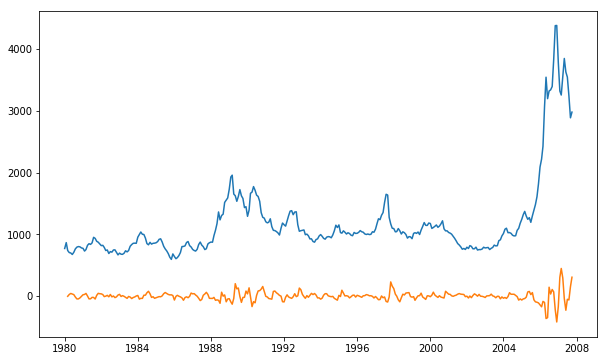

In [72]:
plt.plot(traindata)
plt.plot(model_ar_fit.fittedvalues)

In [73]:
from sklearn.metrics import mean_squared_error

In [77]:
len(traindata['Price']),len(model_ar_fit.fittedvalues)

(334, 332)

In [79]:
print("mean squared error", mean_squared_error(traindata['Price'][2:],model_ar_fit.fittedvalues))

mean squared error 1819837.680158116


In [ ]:
#Forecast the prices using the new model

In [99]:
pred=model_ar_fit.forecast(steps=434)
pred

(array([ 3178.81127606,  3330.83821944,  3351.12956225,  3261.24963031,
         3151.66911559,  3108.11125573,  3156.69334887,  3259.20237918,
         3350.99431284,  3388.10452642,  3371.2161887 ,  3335.83974951,
         3322.09129488,  3347.82730464,  3401.76455221,  3456.84452941,
         3490.98594302,  3500.28961369,  3497.75238702,  3501.34842546,
         3521.39054436,  3555.47694611,  3592.69834818,  3622.45522069,
         3641.23223124,  3653.38569661,  3666.68733308,  3686.59570176,
         3713.21759286,  3742.35774047,  3769.1250014 ,  3791.23378173,
         3809.93418675,  3828.46636545,  3849.55386641,  3873.75426598,
         3899.55212754,  3924.77012808,  3948.11230866,  3969.81606021,
         3991.17844758,  4013.49779395,  4037.23568359,  4061.89402301,
         4086.5370244 ,  4110.48650335,  4133.70562843,  4156.68863069,
         4180.0309017 ,  4204.02367654,  4228.52969118,  4253.16131615,
         4277.58300321,  4301.7169096 ,  4325.73925988,  4349.91

Text(0.5, 1.0, 'Future Forecast')

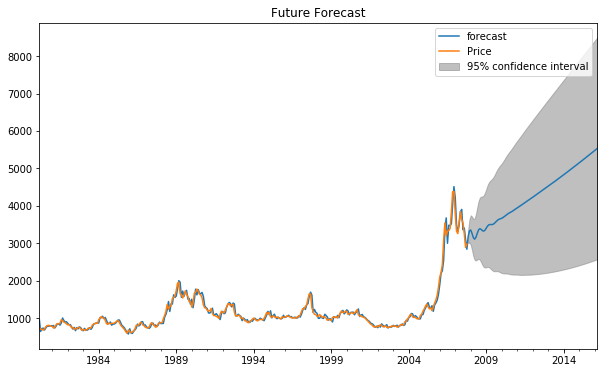

In [98]:
model_ar_fit.plot_predict(2,434)
plt.title("Future Forecast")

In [104]:
# Removing log values from df_log
pred_ARIMA_diff=pd.Series(model_ar_fit.fittedvalues,copy=True)
pred_ARIMA_diff.head()

Date
1980-03-01     0.080757
1980-04-01    29.432742
1980-05-01    46.321517
1980-06-01    35.885489
1980-07-01    27.419448
dtype: float64